In [1]:
# Load scripts without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Runtime benchmarking

This original motivation for this implementation was to improve its computational efficiency, and the code was developed with this in mind. This notebook presents some brief analysis of the scaling of processing time with different parameter settings.

In [2]:
import pandas as pd
import numpy as np
import stats.knox as kx
import matplotlib.pyplot as plt

First open sample data for **burglary** in **Chicago**, derived from the [Crime Open Database (CODE)](https://osf.io/zyaqn/) as explained in [Prepare example data](Prepare%20example%20data.ipynb).

In [3]:
data = pd.read_csv("../data/chicago_burglary_2014_2017.csv", 
                   parse_dates=['date_single'], 
                   dayfirst=True)

data.shape

(45319, 3)

The full dataset contains 45,319 incidents.

## Initial testing

As a basic test, run the Knox test in simple form, applied to a sub-set of incidents. First filter the data to only consider data for 2014.

In [4]:
data_subset = data[data['date_single'] <= pd.to_datetime('2014-12-31')]
data_subset.to_csv("../data/chicago_burglary_2014.csv", 
                   columns=['x','y','date_single'], 
                   date_format='%d/%m/%Y', index=False)

data_subset.shape

(12334, 3)

This dataset contains 12,334 incidents. Then time execution for the algorithm in the following simple configuration:

- __1__ spatial band of **200 metres**
- __1__ temporal band of **7 days**
- **99** iterations

In [5]:
xy = data_subset[['x','y']]
t = (data_subset['date_single'] - pd.to_datetime('2014-01-01')).dt.days

%timeit kx.knox_test(xy, t, s_bands=[200], t_bands=[7], n_iter=99)

3.96 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The execution takes around 4 seconds, running on a Windows 10 laptop with Intel Core i7-5500U processor and 16GB of RAM. 

For comparison, running the dataset in the Near Repeat Calculator in identical configuration takes around 8 minutes 30 seconds (i.e. 510 seconds) - see [here](nrc_output/chicago_burglary_2014_NRsummary.htm).

## Iteration count

Now to examine the scaling of performance with **n_iter** (i.e. the number of iterations). For efficiency, consider only the first 3 months of data.

In [6]:
data_subset = data[data['date_single'] <= pd.to_datetime('2014-03-31')]
xy = data_subset[['x','y']]
t = (data_subset['date_single'] - pd.to_datetime('2014-01-01')).dt.days

Then time execution for a range of **n_iter** values:

In [7]:
iterations = np.arange(19, 200, 20)
iterations_runtime = []
for n_iter in iterations:
    timing = %timeit -o kx.knox_test(xy, t, s_bands=[200], t_bands=[7], n_iter=n_iter)
    iterations_runtime.append(timing.average)

237 ms ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
388 ms ± 56.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
496 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
616 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
809 ms ± 73.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
934 ms ± 64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 91.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.46 s ± 84.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Plot the results:

Text(0, 0.5, 'Runtime (seconds)')

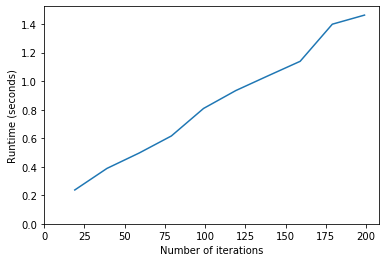

In [8]:
plt.plot(iterations, iterations_runtime)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Number of iterations')
plt.ylabel('Runtime (seconds)')

The scaling appears to be essentially linear - since each step essentially involves an equivalent element-wise matrix multiplication, this is to be expected.

## Number of incidents

Runtime would also be expected to scale with the number of incidents. Examine this by running the algorithm on cumulative 3-month slices of data. Define cutpoints as follows:

In [9]:
limits = pd.date_range('2014-03-01', periods=8, freq='3M')
print(limits)

DatetimeIndex(['2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31'],
              dtype='datetime64[ns]', freq='3M')


Run the algorithm for each temporal slice, using the same spatial and temporal bands as above and with 19 iterations in each case.

In [10]:
n_events = []
n_events_runtime = []
for date in limits:
    data_subset = data[data['date_single'] <= date]
    n_events.append(data_subset.shape[0])
    xy = data_subset[['x','y']]
    t = (data_subset['date_single'] - pd.to_datetime('2014-01-01')).dt.days
    timing = %timeit -o kx.knox_test(xy, t, s_bands=[200], t_bands=[7], n_iter=19)
    n_events_runtime.append(timing.average)

239 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
587 ms ± 70.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
907 ms ± 43.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 55.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.73 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.75 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.97 s ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.36 s ± 53.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Plot the results:

Text(0, 0.5, 'Runtime (seconds)')

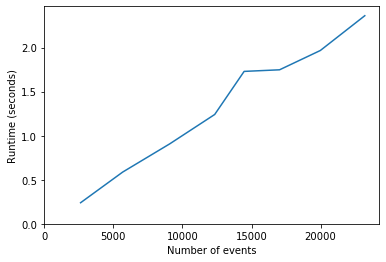

In [11]:
plt.plot(n_events, n_events_runtime)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Number of events')
plt.ylabel('Runtime (seconds)')

In this case, the scaling is again broadly linear. This is more surprising - in principle, for a dataset containing $n$ incidents, the Knox test involves $\frac{1}{2}n(n-1)$ pairwise comparisons between events, and so the runtime would be expected to scale as $\mathcal{O}(n^2)$.

In this case, the initial computation of close pairs (which is the only real heavy lifting involved) is done via the scikit-learn function `radius_neighbors_graph`, which makes use of a [BallTree](https://en.wikipedia.org/wiki/Ball_tree). This indexing is the main source of efficiency in the algorithm.